In [ ]:
#Following Visium H&E tutorial: from https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_visium_hne.html 

import scanpy as sc
import squidpy as sq
import anndata as ad
import pandas as pd
from PIL import Image
import json

highres_path = "tonsils_data_spatial/spatial/tissue_hires_image.png"
img = Image.open(highres_path)

with open("tonsils_data_spatial/spatial/scalefactors_json.json") as f:
    scalefactors = json.load(f)

lowres_scale = scalefactors["tissue_lowres_scalef"]

target_width = int(img.width * lowres_scale)
target_height = int(img.height * lowres_scale)
lowres_img = img.resize((target_width, target_height))

lowres_img.save("tonsils_data_spatial/spatial/tissue_lowres_image.png")

In [12]:
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

adata = sc.read_visium("tonsils_data_spatial", load_images=True)

scanpy==1.10.3 anndata==0.10.8 umap==0.5.9.post2 numpy==1.23.5 scipy==1.13.1 pandas==2.3.2 scikit-learn==1.6.1 statsmodels==0.14.5 igraph==0.11.9 louvain==0.8.2 pynndescent==0.5.13
squidpy==1.6.1


/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
#standard scanpy clustering and umap workflow
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata

AnnData object with n_obs × n_vars = 2012 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

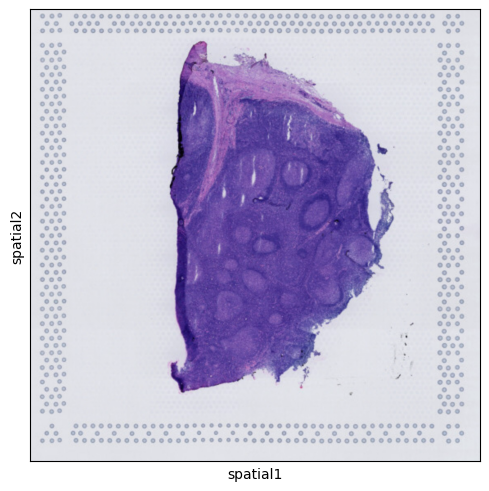

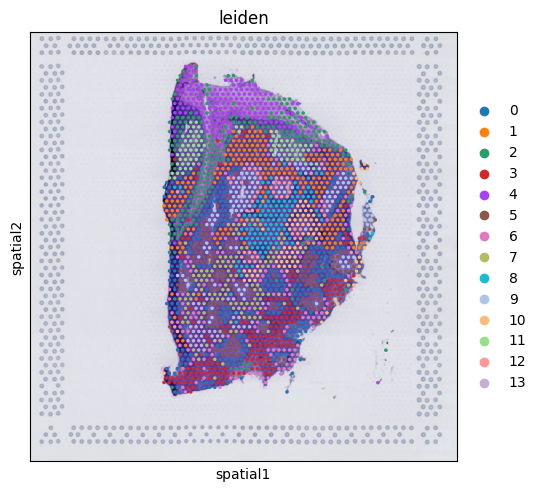

In [14]:
sq.pl.spatial_scatter(adata, size=1)
sq.pl.spatial_scatter(adata, color="leiden", size=1)

In [15]:
#we are so backkkk
import json
img_path = "tonsils_data_spatial/spatial/tissue_hires_image.png"
img = sq.im.ImageContainer(img_path)


scl = scalefactors["tissue_hires_scalef"]
adata.obsm["spatial"] = adata.obsm["spatial"].copy() * scl
#scaling the coordinates to match the highres image

# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )

# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f],
    axis="columns",
)

# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(
    adata.obsm["features"].columns
)

  0%|          | 0/2012 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: Runtim

  0%|          | 0/2012 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [16]:
adata.obsm["features"].head()

,summary_ch-0_quantile-0.9,summary_ch-0_quantile-0.5,summary_ch-0_quantile-0.1,summary_ch-0_mean,summary_ch-0_std,summary_ch-1_quantile-0.9,summary_ch-1_quantile-0.5,summary_ch-1_quantile-0.1,summary_ch-1_mean,summary_ch-1_std,...,summary_ch-1_quantile-0.9-1,summary_ch-1_quantile-0.5-1,summary_ch-1_quantile-0.1-1,summary_ch-1_mean-1,summary_ch-1_std-1,summary_ch-2_quantile-0.9-1,summary_ch-2_quantile-0.5-1,summary_ch-2_quantile-0.1-1,summary_ch-2_mean-1,summary_ch-2_std-1
AAACAAGTATCTCCCA-1,120.0,107.0,96.0,106.875433,8.869589,113.0,97.0,85.0,98.089965,10.147640,...,112.0,97.0,84.0,97.585640,9.931536,179.0,168.0,158.0,167.862457,7.576549
AAACAATCTACTAGCA-1,147.0,139.0,129.0,138.605536,6.592706,91.0,86.0,78.0,85.214533,5.763115,...,91.0,85.5,78.0,84.791522,5.525402,173.0,167.0,160.0,166.678201,5.497584
AAACCGTTCGTCCAGG-1,108.2,99.0,90.0,98.737024,6.671225,80.0,71.0,66.0,72.262976,5.621884,...,80.0,71.0,65.0,71.811419,5.407838,167.0,158.0,154.0,159.511246,5.194725
AAACCTAAGCAGCCGG-1,172.2,109.0,80.0,115.861592,33.809688,173.4,109.0,81.8,115.892734,34.272553,...,176.0,108.0,82.0,115.404844,33.911274,203.0,167.0,148.0,169.831315,19.714970
AAACGAAGAACATACC-1,173.2,167.0,156.8,164.792388,10.764150,145.0,138.0,126.0,135.266436,12.231969,...,144.0,137.0,125.0,134.829585,11.869877,201.0,194.0,183.0,191.395329,12.376809


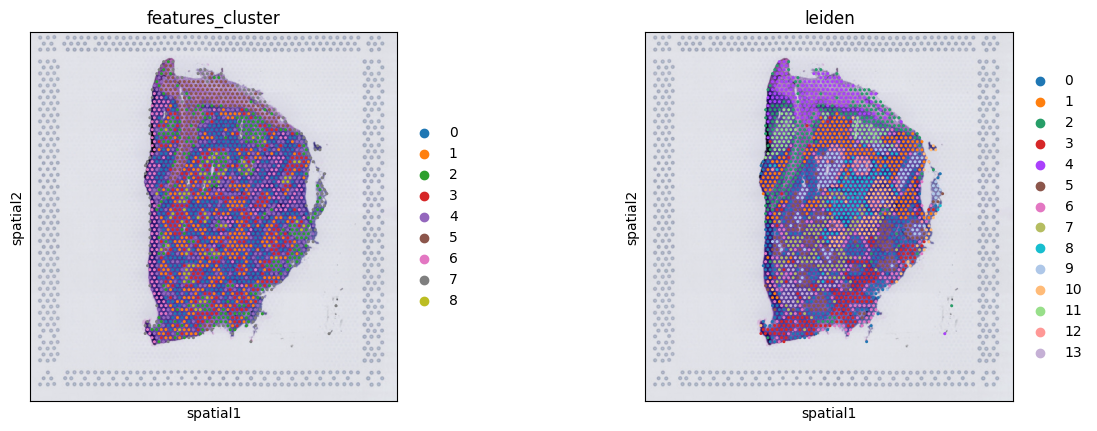

In [17]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    #like is a string to filter the features
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(15, features.shape[1] - 1))
    sc.pp.neighbors(adata, n_pcs=15)
    sc.tl.leiden(adata, resolution=0.4)

    return adata.obs["leiden"]

# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

adata.obsm["spatial"] = adata.obsm["spatial"].copy() / scl
# divide by scl to get back to original coordinates for plotting

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "leiden"], size= 1)

  0%|          | 0/1000 [00:00<?, ?/s]

/Users/anushkadole/PDAC-scRNA/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


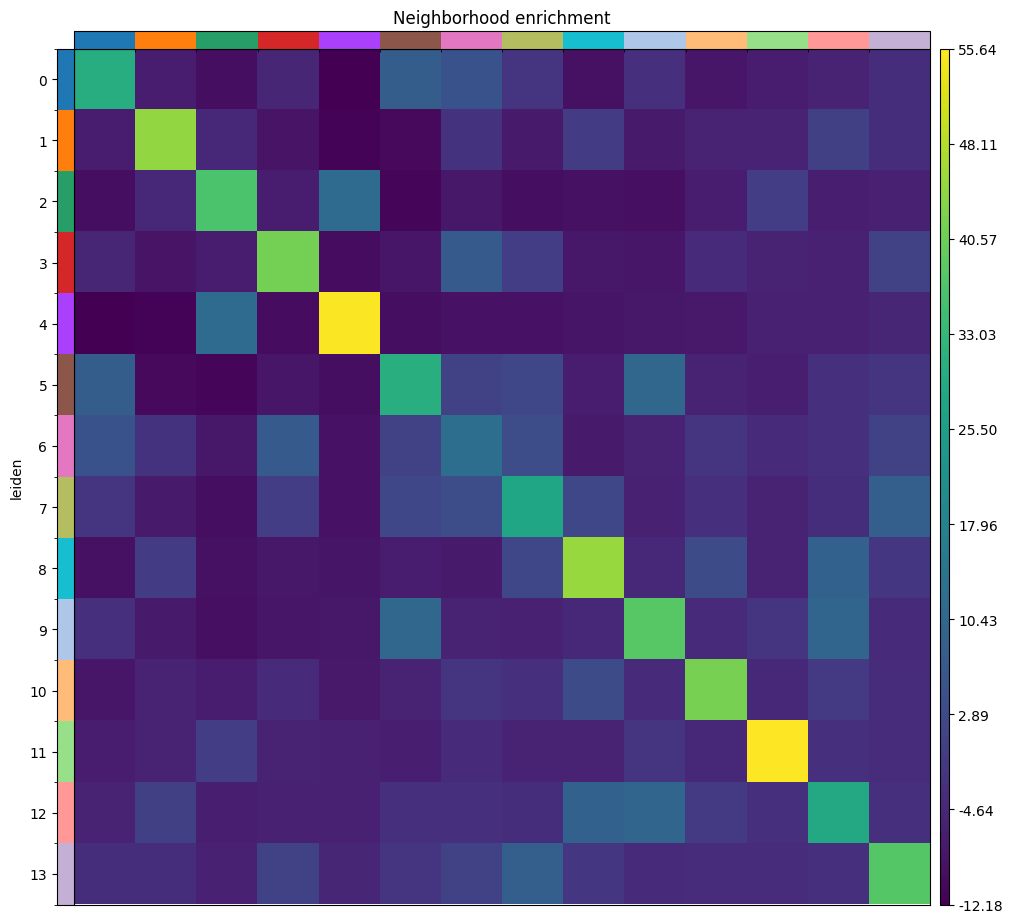

In [23]:
#Neighborhood Enrichment
adata.obs
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(adata, cluster_key="leiden")